# Covariance Optimization with Divergence-Free Transformation

This notebook demonstrates:
1. Sampling points from a uniform distribution
2. Creating a divergence-free transformation with 5 centers
3. Optimizing coefficients to minimize covariance determinant
4. Visualizing before/after distributions
5. Tracking entropy throughout optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from entra import (
    VectorSampler, TensorBasis, Transformation, CovarianceMinimizer,
    EffectiveTransformation, EffectiveCovarianceMinimizer,
    shannon_entropy_gaussian, shannon_entropy_uniform, shannon_entropy_knn, plot_covariance_ellipse
)

## Step 1: Sample Points from Uniform Distribution

In [2]:
# Parameters
num_points_per_dim = 20  # 10 points per dimension
delta_x = 1          # Grid spacing in both x and y
sigma = 5   # Sigma for tensor basis
# Create sampler centered at origin
sampler = VectorSampler(
    center=[0.0, 0.0],
    delta_x=delta_x,
    num_points_per_dim=num_points_per_dim,
    distribution="uniform"
)

# Sample the grid points
eval_points = sampler.sample()
J = sampler.J
grid_shape = sampler.num_points_per_dim

print(f"Grid: {num_points_per_dim} x {num_points_per_dim} = {J} points")
print(f"Grid shape: {grid_shape}")
print(f"delta_x = {delta_x}")
print(f"sigma = {sigma}")
print(f"\neval_points shape: {eval_points.shape}  (J, D)")

Grid: 20 x 20 = 400 points
Grid shape: (20, 20)
delta_x = 1
sigma = 5

eval_points shape: (400, 2)  (J, D)


/tmp/ipykernel_3312550/2107535393.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


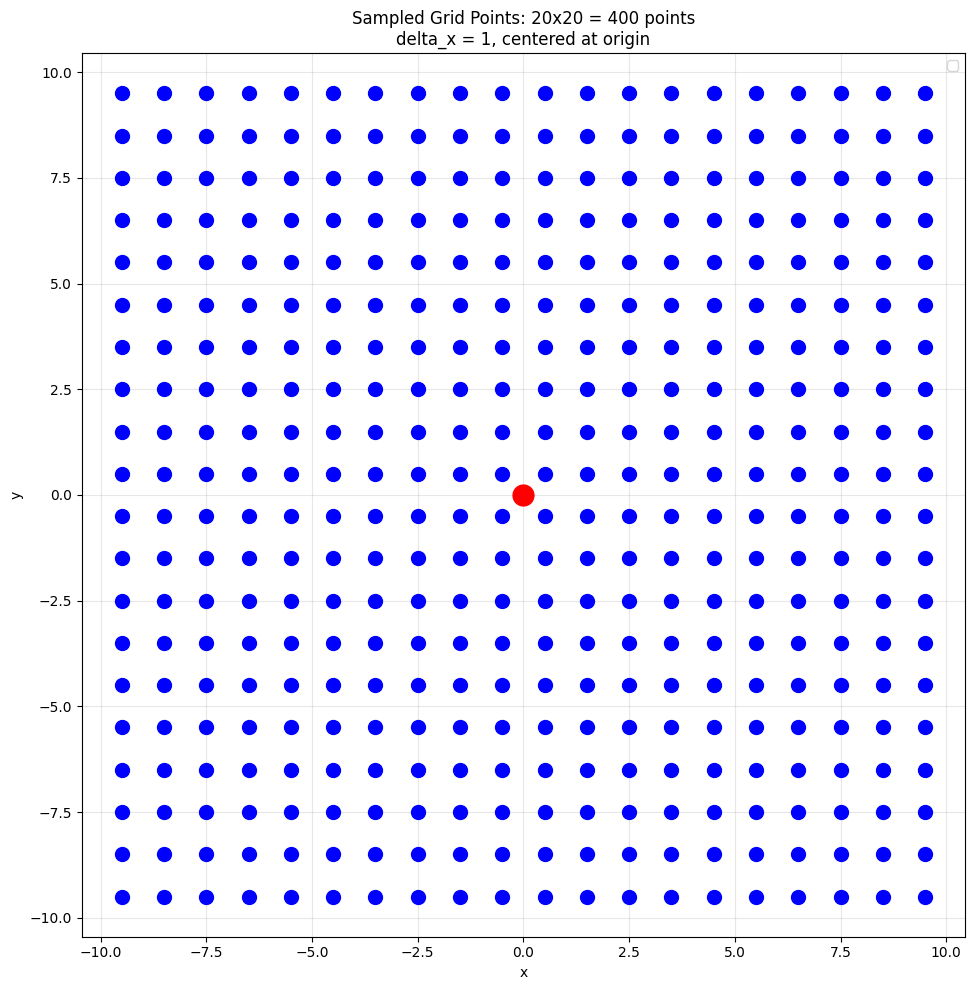


Grid extent:
  x: [-9.50, 9.50]
  y: [-9.50, 9.50]


In [3]:
# Visualize the grid with point indices
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all points
ax.scatter(eval_points[:, 0], eval_points[:, 1], c='blue', s=100, zorder=2)



# Mark the center (origin)
ax.plot(0, 0, 'ro', markersize=15, zorder=3)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Sampled Grid Points: {num_points_per_dim}x{num_points_per_dim} = {J} points\n'
             f'delta_x = {delta_x}, centered at origin')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.legend()
plt.tight_layout()
plt.show()

# Print grid extent
print(f"\nGrid extent:")
print(f"  x: [{eval_points[:, 0].min():.2f}, {eval_points[:, 0].max():.2f}]")
print(f"  y: [{eval_points[:, 1].min():.2f}, {eval_points[:, 1].max():.2f}]")

In [4]:
# Initial statistics
initial_mean = np.mean(eval_points, axis=0)
initial_cov = np.cov(eval_points, rowvar=False)
initial_det = np.linalg.det(initial_cov)
initial_entropy_uniform = shannon_entropy_uniform(eval_points)
initial_entropy_knn = shannon_entropy_knn(eval_points)

print("Initial Distribution Statistics (Uniform):")
print(f"  Mean: [{initial_mean[0]:.4f}, {initial_mean[1]:.4f}]")
print(f"  Covariance:")
print(f"    [[{initial_cov[0,0]:.6f}, {initial_cov[0,1]:.6f}],")
print(f"     [{initial_cov[1,0]:.6f}, {initial_cov[1,1]:.6f}]]")
print(f"  Determinant: {initial_det:.6e}")
print(f"  Entropy (uniform): {initial_entropy_uniform:.6f} nats")
print(f"  Entropy (k-NN):    {initial_entropy_knn:.6f} nats")

Initial Distribution Statistics (Uniform):
  Mean: [0.0000, 0.0000]
  Covariance:
    [[33.333333, 0.000000],
     [0.000000, 33.333333]]
  Determinant: 1.111111e+03
  Entropy (uniform): 5.888878 nats
  Entropy (k-NN):    7.605385 nats


In [5]:
center_list = []
for i in range(int(eval_points[:, 0].max())):
  center_list.append([i, 0.0])
  center_list.append([-i, 0.0])
  center_list.append([ 0.0, i])
  center_list.append([0.0, -i])
centers = np.asarray(center_list)  


## Step 2: Create 5 Centers and Transformation

In [6]:
# Create basis and transformation
basis = TensorBasis(centers, sigma=sigma)
transformation = Transformation(basis)

print(f"TensorBasis: L={basis.L}, D={basis.D}, sigma={sigma}")
print(f"Transformation: {transformation.num_parameters} parameters (L x D = {centers.shape} x {eval_points.shape[1]})")

TensorBasis: L=36, D=2, sigma=5
Transformation: 72 parameters (L x D = (36, 2) x 2)


## Step 3: Optimize Coefficients (Levenberg-Marquardt)

In [7]:
# Create minimizer
minimizer = CovarianceMinimizer(transformation, eval_points)

# Track optimization history
history = {
    'iteration': [],
    'determinant': [],
    'entropy': [],
    'log_det': []
}

# Custom optimization to record each step
x = transformation.get_coefficients_flat().copy()
n_params = len(x)

lam = 1.0  # Damping
eps = 1e-7
max_iter = 1000
tol = 1e-18

# Record initial
cov = minimizer.compute_covariance(x)
det_val = np.linalg.det(cov)
entropy = shannon_entropy_uniform(cov)
history['iteration'].append(0)
history['determinant'].append(det_val)
history['entropy'].append(entropy)
history['log_det'].append(np.log(det_val))

print(f"{'Iter':>5}  {'Determinant':>14}  {'Entropy':>12}  {'log(det)':>12}")
print("-" * 50)
print(f"{0:>5}  {det_val:>14.6e}  {entropy:>12.6f}  {np.log(det_val):>12.6f}")

for iteration in range(1, max_iter + 1):
    r = minimizer.residuals_for_lm(x)
    
    # Jacobian
    J_mat = np.zeros((len(r), n_params))
    for i in range(n_params):
        x_plus = x.copy()
        x_plus[i] += eps
        J_mat[:, i] = (minimizer.residuals_for_lm(x_plus) - r) / eps
    
    # LM step
    JTJ = J_mat.T @ J_mat
    JTr = J_mat.T @ r
    
    try:
        delta = np.linalg.solve(JTJ + lam * np.eye(n_params), -JTr)
    except:
        delta = -JTr / (np.diag(JTJ) + lam + 1e-10)
    
    x_new = x + delta
    obj_new = minimizer.objective_logdet(x_new)
    obj_old = minimizer.objective_logdet(x)
    #print(f'obj new {obj_new}, obj old {obj_old}')
    if obj_new < obj_old:
        x = x_new
        lam *= 0.1
        improvement = abs(obj_old - obj_new)
        
        cov = minimizer.compute_covariance(x)
        det_val = np.linalg.det(cov)
        entropy = shannon_entropy_gaussian(cov)
        
        history['iteration'].append(iteration)
        history['determinant'].append(det_val)
        history['entropy'].append(entropy)
        history['log_det'].append(np.log(det_val))
        
        if iteration % 5 == 0 or iteration <= 5:
            print(f"{iteration:>5}  {det_val:>14.6e}  {entropy:>12.6f}  {np.log(det_val):>12.6f}")
        
        if improvement < tol:
            print(improvement, tol)
            print(f"\nConverged at iteration {iteration}")
            break
    else:
        lam *= 10.0

print(f"\nFinal: det = {det_val:.6e}, entropy = {entropy:.6f}")

 Iter     Determinant       Entropy      log(det)
--------------------------------------------------
    0    1.111111e+03      7.013116      7.013116
    1    1.111108e+03      6.344434      7.013113
    2    1.111079e+03      6.344421      7.013087
    3    1.110790e+03      6.344290      7.012827
    4    1.107916e+03      6.342995      7.010236
    5    1.080888e+03      6.330646      6.985538
   15    9.362160e+02      6.258800      6.841846
   35    9.359711e+02      6.258669      6.841585
   45    9.358638e+02      6.258612      6.841470
   50    9.358081e+02      6.258582      6.841410
   60    9.356994e+02      6.258524      6.841294
   70    9.355946e+02      6.258468      6.841182
   80    9.354927e+02      6.258414      6.841073
   90    9.353932e+02      6.258361      6.840967
  115    9.351363e+02      6.258223      6.840692
  125    9.350414e+02      6.258172      6.840591
  130    9.349966e+02      6.258149      6.840543
  135    9.349484e+02      6.258123      6.840491

In [8]:
# Set final coefficients
transformation.set_coefficients_flat(x)


## Step 5: Optimization Progress

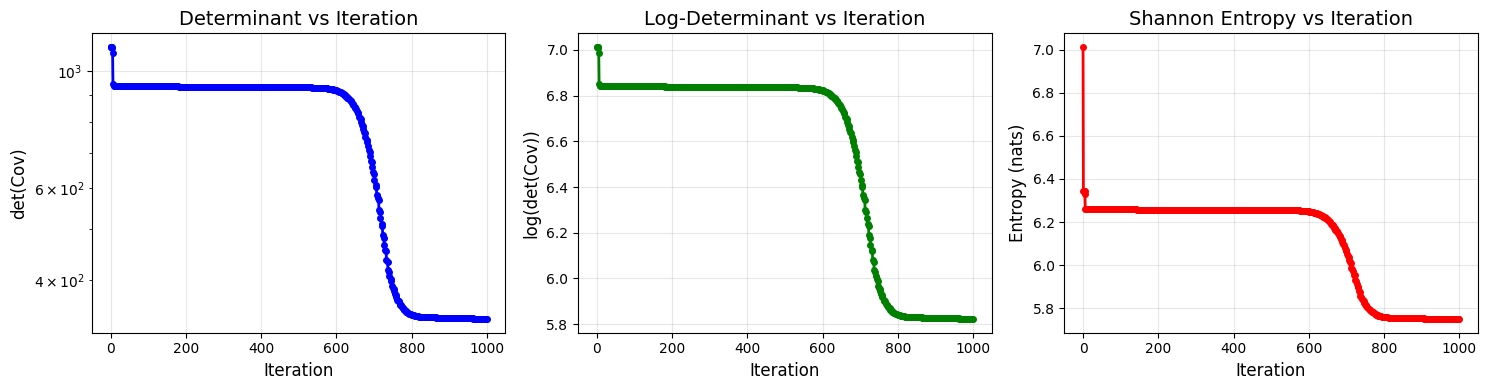

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Determinant
ax0 = axes[0]
ax0.semilogy(history['iteration'], history['determinant'], 'b.-', linewidth=2, markersize=8)
ax0.set_xlabel('Iteration', fontsize=12)
ax0.set_ylabel('det(Cov)', fontsize=12)
ax0.set_title('Determinant vs Iteration', fontsize=14)
ax0.grid(True, alpha=0.3)

# Log determinant
ax1 = axes[1]
ax1.plot(history['iteration'], history['log_det'], 'g.-', linewidth=2, markersize=8)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('log(det(Cov))', fontsize=12)
ax1.set_title('Log-Determinant vs Iteration', fontsize=14)
ax1.grid(True, alpha=0.3)

# Entropy
ax2 = axes[2]
ax2.plot(history['iteration'], history['entropy'], 'r.-', linewidth=2, markersize=8)
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Entropy (nats)', fontsize=12)
ax2.set_title('Shannon Entropy vs Iteration', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Transform Points and Compare

In [10]:
# Transform points
points_transformed = transformation.transform(eval_points)

# Final statistics
final_mean = np.mean(points_transformed, axis=0)
final_cov = np.cov(points_transformed, rowvar=False)
final_det = np.linalg.det(final_cov)
final_entropy_gaussian = shannon_entropy_gaussian(final_cov)
final_entropy_knn = shannon_entropy_knn(points_transformed)

print("Comparison:")
print(f"{'':20} {'Initial':>14} {'Final':>14} {'Change':>14}")
print("-" * 65)
print(f"{'Determinant':20} {initial_det:>14.6e} {final_det:>14.6e} {initial_det/final_det:>14.2f}x")
print(f"{'Entropy (uniform)':20} {initial_entropy_uniform:>14.6f}")
print(f"{'Entropy (gaussian)':20} {'':>14} {final_entropy_gaussian:>14.6f}")
print(f"{'Entropy (k-NN)':20} {initial_entropy_knn:>14.6f} {final_entropy_knn:>14.6f} {initial_entropy_knn - final_entropy_knn:>14.6f}")

Comparison:
                            Initial          Final         Change
-----------------------------------------------------------------
Determinant            1.111111e+03   3.376939e+02           3.29x
Entropy (uniform)          5.888878
Entropy (gaussian)                        5.748947
Entropy (k-NN)             7.605385       6.365254       1.240131


In [11]:
# Get updated basis after first iteration
updated_basis = transformation.get_updated_basis(eval_points)  # (J, L, D)

# Outer loop with updated basis
N_OUTER = 5
outer_history = {
    'round': [0], 
    'determinant': [final_det], 
    'entropy': [final_entropy_gaussian],
    'points': [points_transformed.copy()],
    'covariance': [final_cov.copy()]
}
current_basis = updated_basis.copy()
current_points = points_transformed.copy()

print(f"Starting outer loop with {N_OUTER} rounds")
print(f"Initial basis shape: {current_basis.shape}")
print(f"\n{'Round':>5}  {'Determinant':>14}  {'Entropy':>12}")
print("-" * 40)
print(f"{0:>5}  {final_det:>14.6e}  {final_entropy_gaussian:>12.6f}")

for outer_round in range(1, N_OUTER + 1):
    # Create effective transformation with current basis
    eff_transform = EffectiveTransformation(current_basis, current_points)
    eff_minimizer = EffectiveCovarianceMinimizer(eff_transform)
    
    # Optimize
    result = eff_minimizer.optimize(max_iterations=500, tolerance=1e-10, verbose=False)
    
    # Record results
    round_det = result['final_determinant']
    round_cov = result['final_covariance']
    round_entropy = shannon_entropy_gaussian(round_cov)
    
    # Update points for next round
    current_points = eff_transform.transform()
    current_basis = eff_transform.get_updated_basis()
    
    outer_history['round'].append(outer_round)
    outer_history['determinant'].append(round_det)
    outer_history['entropy'].append(round_entropy)
    outer_history['points'].append(current_points.copy())
    outer_history['covariance'].append(round_cov.copy())
    
    print(f"{outer_round:>5}  {round_det:>14.6e}  {round_entropy:>12.6f}")

print(f"\nFinal reduction: {outer_history['determinant'][0] / outer_history['determinant'][-1]:.2f}x")

Starting outer loop with 5 rounds
Initial basis shape: (400, 36, 2)

Round     Determinant       Entropy
----------------------------------------
    0    3.376939e+02      5.748947
    1    3.358008e+02      5.746136
    2    3.358008e+02      5.746136


/home/debian/python_workspace/entra/src/entra/effective_basis.py:212: RuntimeWarning: invalid value encountered in multiply
  delta = np.linalg.solve(JTJ + lam * np.eye(n_params), -JTr)
/mnt/disk/capedenv/lib/python3.10/site-packages/numpy/linalg/linalg.py:2120: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


    3    3.358008e+02      5.746136
    4    3.358008e+02      5.746136
    5    3.358008e+02      5.746136

Final reduction: 1.01x


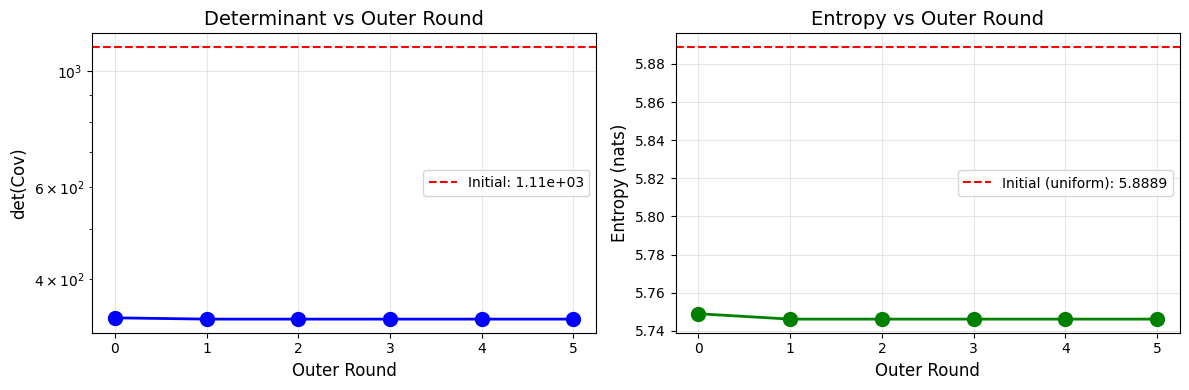

In [12]:
# Plot outer loop progress
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax0 = axes[0]
ax0.semilogy(outer_history['round'], outer_history['determinant'], 'bo-', linewidth=2, markersize=10)
ax0.axhline(initial_det, color='r', linestyle='--', label=f'Initial: {initial_det:.2e}')
ax0.set_xlabel('Outer Round', fontsize=12)
ax0.set_ylabel('det(Cov)', fontsize=12)
ax0.set_title('Determinant vs Outer Round', fontsize=14)
ax0.legend()
ax0.grid(True, alpha=0.3)

ax1 = axes[1]
ax1.plot(outer_history['round'], outer_history['entropy'], 'go-', linewidth=2, markersize=10)
ax1.axhline(initial_entropy_uniform, color='r', linestyle='--', label=f'Initial (uniform): {initial_entropy_uniform:.4f}')
ax1.set_xlabel('Outer Round', fontsize=12)
ax1.set_ylabel('Entropy (nats)', fontsize=12)
ax1.set_title('Entropy vs Outer Round', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

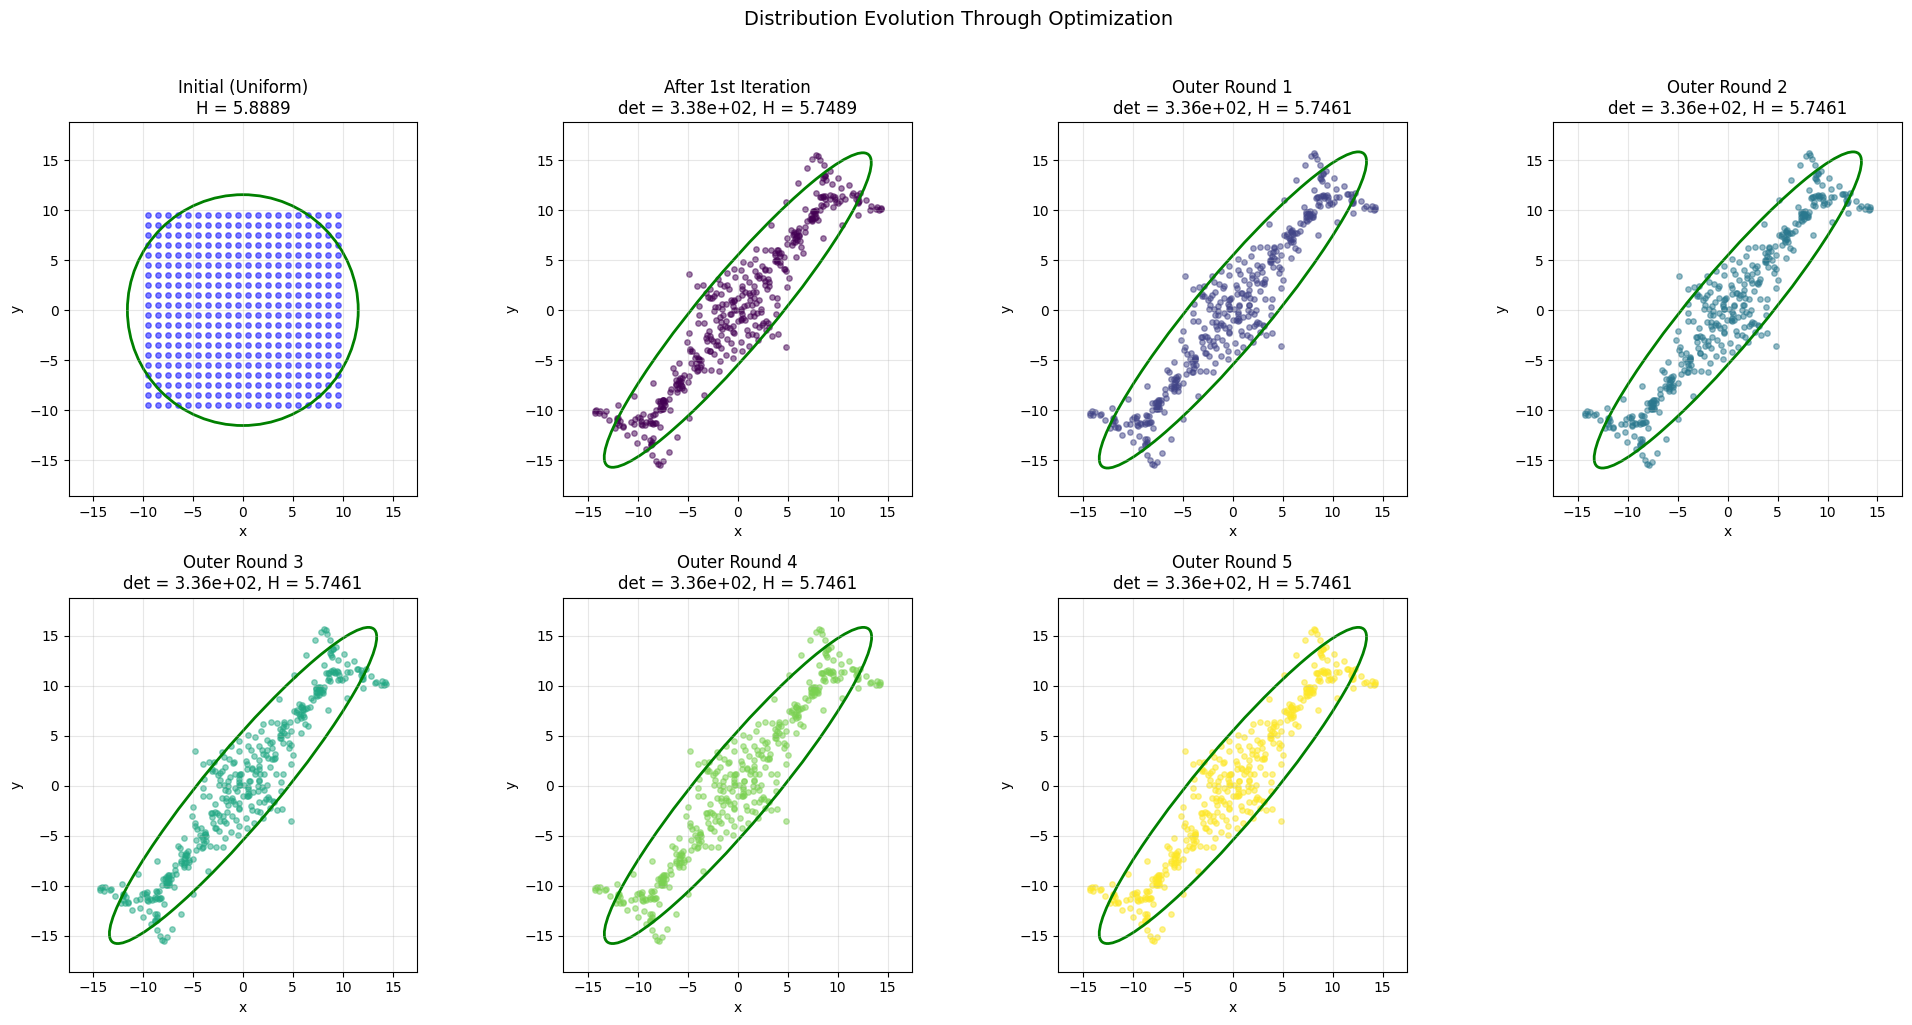

In [13]:
# Visualize distribution evolution through outer loop
n_plots = 1 + len(outer_history['round'])  # Initial + all rounds (round 0 = after 1st iter)
n_cols = min(4, n_plots)
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
axes = np.atleast_2d(axes).flatten()

# Set consistent axis limits
x_min = min(eval_points[:, 0].min(), min(p[:, 0].min() for p in outer_history['points']))
x_max = max(eval_points[:, 0].max(), max(p[:, 0].max() for p in outer_history['points']))
y_min = min(eval_points[:, 1].min(), min(p[:, 1].min() for p in outer_history['points']))
y_max = max(eval_points[:, 1].max(), max(p[:, 1].max() for p in outer_history['points']))
margin = 0.1 * max(x_max - x_min, y_max - y_min)

# Plot 0: Initial uniform distribution
ax = axes[0]
ax.scatter(eval_points[:, 0], eval_points[:, 1], alpha=0.5, s=15, c='blue')
plot_covariance_ellipse(ax, initial_mean, initial_cov, n_std=2, fill=False, color='green', linewidth=2)
ax.set_xlim(x_min - margin, x_max + margin)
ax.set_ylim(y_min - margin, y_max + margin)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title(f'Initial (Uniform)\nH = {initial_entropy_uniform:.4f}')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Plot 1+: After each outer round (round 0 = after first iteration)
for i, (rnd, pts, cov, det, ent) in enumerate(zip(
    outer_history['round'], 
    outer_history['points'],
    outer_history['covariance'],
    outer_history['determinant'],
    outer_history['entropy']
)):
    ax = axes[i + 1]
    mean = np.mean(pts, axis=0)
    
    color = plt.cm.viridis(i / max(1, len(outer_history['round']) - 1))
    ax.scatter(pts[:, 0], pts[:, 1], alpha=0.5, s=15, c=[color])
    plot_covariance_ellipse(ax, mean, cov, n_std=2, fill=False, color='green', linewidth=2)
    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    if rnd == 0:
        ax.set_title(f'After 1st Iteration\ndet = {det:.2e}, H = {ent:.4f}')
    else:
        ax.set_title(f'Outer Round {rnd}\ndet = {det:.2e}, H = {ent:.4f}')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

# Hide unused axes
for j in range(n_plots, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribution Evolution Through Optimization', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Step 7: Visualize Before and After

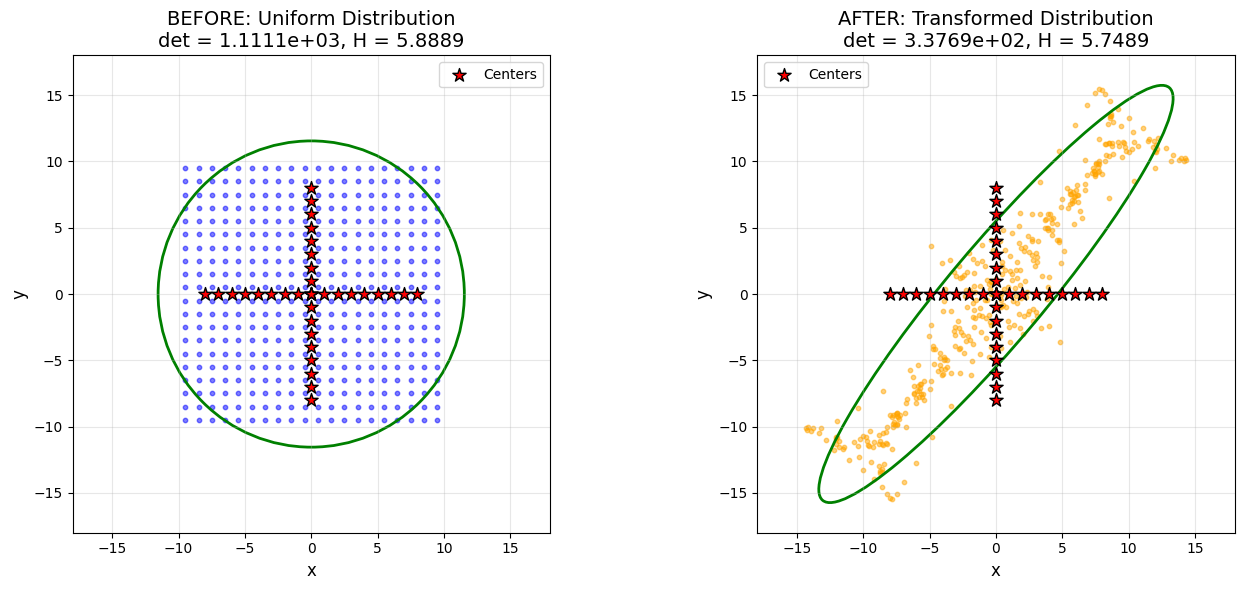

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before transformation
ax0 = axes[0]
ax0.scatter(eval_points[:, 0], eval_points[:, 1], alpha=0.5, s=10, c='blue')
ax0.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='*', 
            zorder=5, edgecolors='black', label='Centers')
plot_covariance_ellipse(ax0, initial_mean, initial_cov, n_std=2,
                        fill=False, color='green', linewidth=2)
ax0.set_xlim(2 * int(eval_points[:, 0].min()), 2 * int(eval_points[:, 0].max()))
ax0.set_ylim(2 * int(eval_points[:, 1].min()), 2 * int(eval_points[:, 0].max()))
ax0.set_xlabel('x', fontsize=12)
ax0.set_ylabel('y', fontsize=12)
ax0.set_title(f'BEFORE: Uniform Distribution\n'
              f'det = {initial_det:.4e}, H = {initial_entropy_uniform:.4f}', fontsize=14)
ax0.set_aspect('equal')
ax0.legend()
ax0.grid(True, alpha=0.3)

# After transformation
ax1 = axes[1]
ax1.scatter(points_transformed[:, 0], points_transformed[:, 1], alpha=0.5, s=10, c='orange')
ax1.scatter(centers[:, 0], centers[:, 1], c='red', s=100, marker='*', 
            zorder=5, edgecolors='black', label='Centers')
plot_covariance_ellipse(ax1, final_mean, final_cov, n_std=2,
                        fill=False, color='green', linewidth=2)
ax1.set_xlim(2 * int(eval_points[:, 0].min()), 2 * int(eval_points[:, 0].max()))
ax1.set_ylim(2 * int(eval_points[:, 1].min()), 2 * int(eval_points[:, 0].max()))
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('y', fontsize=12)
ax1.set_title(f'AFTER: Transformed Distribution\n'
              f'det = {final_det:.4e}, H = {final_entropy_gaussian:.4f}', fontsize=14)
ax1.set_aspect('equal')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 8: Visualize Displacement Field

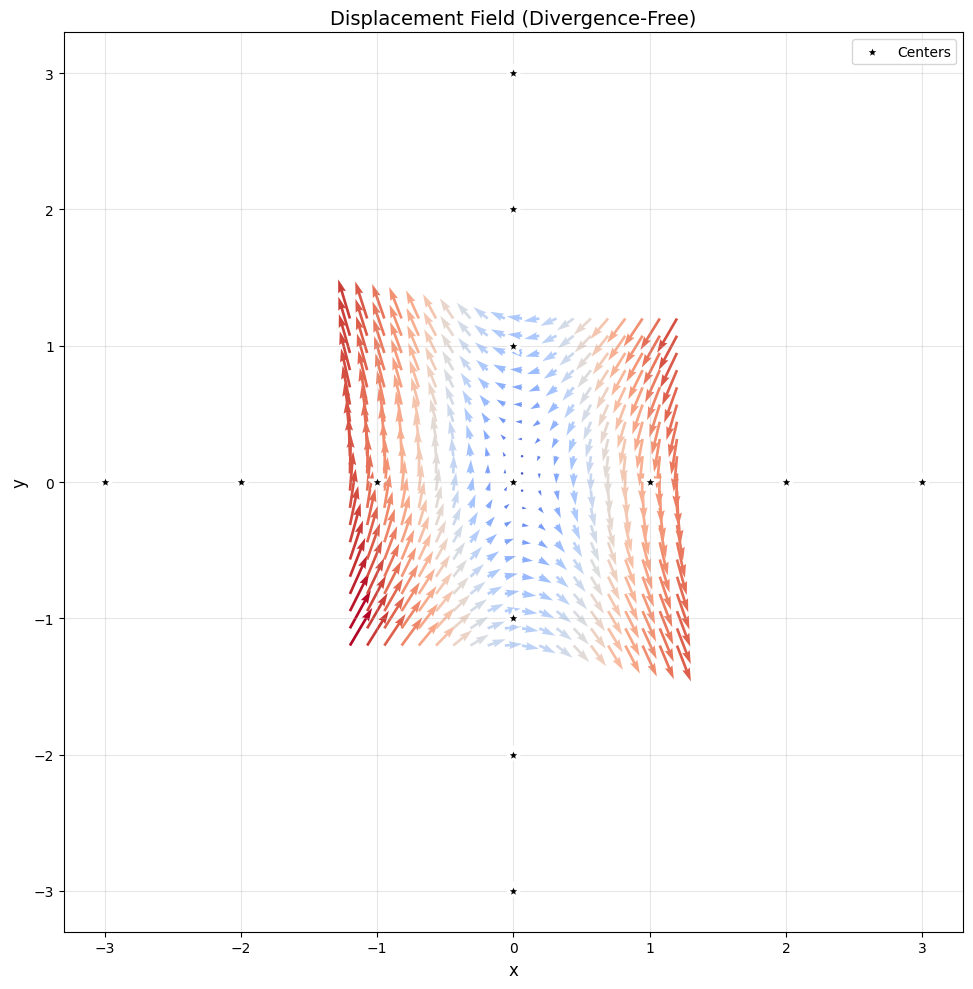

In [15]:
# Create grid for displacement visualization
n_grid = 20
x_grid = np.linspace(-1.2, 1.2, n_grid)
y_grid = np.linspace(-1.2, 1.2, n_grid)
xx, yy = np.meshgrid(x_grid, y_grid, indexing='ij')
grid_points = np.column_stack([xx.ravel(), yy.ravel()])

# Compute displacements
displacements = transformation.get_displacement(grid_points)
dx = displacements[:, 0].reshape(n_grid, n_grid)
dy = displacements[:, 1].reshape(n_grid, n_grid)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot displacement field
mag = np.sqrt(dx**2 + dy**2)
ax.quiver(xx, yy, dx, dy, mag, cmap='coolwarm')

# Plot centers
ax.scatter(centers[:, 0], centers[:, 1], c='black', s=150, marker='*', 
           zorder=5, edgecolors='white', linewidths=2, label='Centers')

ax.set_xlim(-3.3, 3.3)
ax.set_ylim(-3.3, 3.3)
ax.set_xlabel('x', fontsize=12)
ax.set_ylabel('y', fontsize=12)
ax.set_title('Displacement Field (Divergence-Free)', fontsize=14)
ax.set_aspect('equal')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

The optimization found transformation coefficients that:
- Minimize the determinant of the covariance matrix
- Reduce the Shannon entropy of the distribution
- Use divergence-free displacement fields (preserving incompressibility)